In [ ]:
starting_point = 800 #Indices to skip due to lack of buoys.
train_size = 1000+73+73
test_size = 73
lag = 365 #Days to lag by

In [1]:
import netCDF4 as nc
import os
import numpy as np
import julian
import numpy.ma as ma

In [2]:
import subprocess

for subfolder in os.listdir('data'):
    if subfolder.find(".")<0 :
        contents = os.listdir("data/" +subfolder)
        print(subfolder)
        print(contents[0:5])
        print(len(contents))
        if len(contents) <5:
            #identify the file
            target = 0
            for i,x in enumerate(contents):
                if x.find(".tar")>0:
                    target=i
            os.system("tar -xvf data/"+subfolder+"/'"+contents[target]+"' -C data/"+subfolder)
        contents = os.listdir("data/" +subfolder)
        if sum([i.find(".cdf.gz")>0 for i in contents])>0:
            os.system("gunzip data/"+subfolder+"/*.gz")

sst_anom
['README_sst.txt', 'sst_anom_0n110w_5day.cdf', 'sst_anom_0n156e_5day.cdf', 'read_netcdf.f', 'sst_anom_0n165e_5day.cdf']
17


In [3]:
path_to_anomaly = "data/sst_anom"
path = path_to_anomaly
anomaly_files = [path+"/" + file for file in os.listdir(path) if file.find(".cdf")>0]

In [4]:
from netCDF4 import MFDataset
from netCDF4 import Dataset

anomalies = [f for f in anomaly_files if f.find("anom_")>0]

anom_datasets = [Dataset(c) for c in anomalies]
bound1 = 360-110+1
bound2 = 360-170-1
#NINO 3.4 is 110W to 170W, 5S to 5N. These files are from along the equator, usefully.
anom_datasets[0]['lon'][0].data, anom_datasets[1]['lon'][0].data, anomalies
longitudes = np.array([c['lon'][0].data for c in anom_datasets])

anomalies_filtered = list(np.array(anomalies)[(longitudes <bound1) & (longitudes > bound2)])



anomalies_ds = MFDataset(anomalies_filtered, aggdim = 'time')

In [5]:
times_set = set(anomalies_ds['time'][:])
times = anomalies_ds['time'][:]
T_25 = anomalies_ds['T_25'][:]
times[0], times[-1]

(2444306, 2459151)

In [6]:
all_times = np.array(sorted(times_set))
dates = np.array([julian.from_jd(t, 'jd') for t in all_times])
month_key = [(d.year, d.month) for d in dates]
month_key_unique = sorted(set(month_key))

In [7]:
#Process:
'''
For each label in month_key_unique, get it and the previous two keys.
'''
running_averages = []
for i in range(2, len(month_key_unique)):    
    months = [month_key_unique[i-j] for j in range(3)]
    mask = [m in months for m in month_key]
    time_window = set(all_times[mask])
    include = [t in time_window for t in times]
    to_average = [T_25[i] for i in range(len(T_25)) if include[i] and T_25[i]<1e10]
    running_averages.append(np.mean(to_average))
running_averages = np.array(running_averages)

/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
data_items = {}
for subfolder in os.listdir('data'):
    if subfolder.find(".cdf")>0:
        if subfolder.find("anom")<10000:
            path = "data/"+subfolder

            d = Dataset(path)
            dims = d.dimensions
            vals = d.variables.keys()
            values = {k:d[k][:] for k in vals}
            data_items[subfolder]=values
cdf_files = ["data/" + file for file in os.listdir("data") if file.find(".cdf")>0]
data_files = [Dataset(c) for c in cdf_files]
cdf_files

['data/wdir_xyt_5day.cdf',
 'data/sss_xyt_5day.cdf',
 'data/rh_xyt_5day.cdf',
 'data/t_xyzt_5day_100.cdf',
 'data/cur_xyzt_5day.cdf',
 'data/sst_anom_xyt_5day.cdf',
 'data/vwnd_xyt_5day.cdf',
 'data/bp_xyt_5day.cdf',
 'data/wspd_xyt_5day.cdf',
 'data/sst_xyt_5day.cdf',
 'data/t_xyzt_5day_500.cdf',
 'data/uwnd_xyt_5day.cdf',
 'data/airt_xyt_5day.cdf',
 'data/t_xyzt_5day_300.cdf']

In [9]:
#Data requirements:
#All sites in one file
#One variable
#Select all sites
#Netcdf, 4 byte, julian
#1979, Jan 20.
#5-day

In [10]:
fills = np.array([d['time'][:].fill_value for d in data_files])
start_time = 2443895
julian.from_jd(start_time, 'jd')
mod_ = start_time*(fills > 1e10)
fixed_times = [d['time'][:] for d in data_files]+mod_
to_find = 2450000
finding_values = [list(np.array(d)>to_find).index(True) for d in fixed_times]
#Check if it's less than 0 to see if it's 'missing'

<ipython-input-10-e4cb28bdfdd5>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  fixed_times = [d['time'][:] for d in data_files]+mod_


In [11]:
def find_data_indices(date, arrays=fixed_times):
    return [list(np.array(d)>date).index(True) for d in arrays]

In [12]:
#Okay. I've got it all on the same scale. Next step- getting a specific day.
cdf_files

['data/wdir_xyt_5day.cdf',
 'data/sss_xyt_5day.cdf',
 'data/rh_xyt_5day.cdf',
 'data/t_xyzt_5day_100.cdf',
 'data/cur_xyzt_5day.cdf',
 'data/sst_anom_xyt_5day.cdf',
 'data/vwnd_xyt_5day.cdf',
 'data/bp_xyt_5day.cdf',
 'data/wspd_xyt_5day.cdf',
 'data/sst_xyt_5day.cdf',
 'data/t_xyzt_5day_500.cdf',
 'data/uwnd_xyt_5day.cdf',
 'data/airt_xyt_5day.cdf',
 'data/t_xyzt_5day_300.cdf']

In [13]:



start_x = find_data_indices(all_times[starting_point])
#What files to use?
start_x

[719, 0, 8, 800, 791, 719, 719, 0, 719, 719, 800, 719, 718, 800]

In [14]:
file_names = ["data/cur_xyzt_5day.cdf", "data/vwnd_xyt_5day.cdf", "data/sst_xyt_5day.cdf",
              "data/uwnd_xyt_5day.cdf", "data/rh_xyt_5day.cdf", "data/airt_xyt_5day.cdf"]

In [15]:
features_select = [i in file_names for i in cdf_files]
features_select

[False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False]

In [17]:
to_use = np.array(data_files)[features_select]
files_used = np.array(cdf_files)[features_select]
[print(f, k.variables.keys()) for k, f in list(zip(to_use, files_used))]
1

data/rh_xyt_5day.cdf dict_keys(['time', 'time2', 'depth', 'lat', 'lon', 'RH_910', 'QRH_5910', 'SRH_6910'])
data/cur_xyzt_5day.cdf dict_keys(['lon', 'lat', 'depth', 'time2', 'time', 'U_320', 'V_321', 'S_300', 'D_310', 'QS_5300', 'QD_5310', 'SRC_6300'])
data/vwnd_xyt_5day.cdf dict_keys(['time', 'time2', 'depth', 'lat', 'lon', 'WV_423', 'QWV_5423', 'SWV_6423'])
data/sst_xyt_5day.cdf dict_keys(['time', 'time2', 'depth', 'lat', 'lon', 'T_20', 'QT_5020', 'ST_6020'])
data/uwnd_xyt_5day.cdf dict_keys(['time', 'time2', 'depth', 'lat', 'lon', 'WU_422', 'QWU_5422', 'SWU_6422'])
data/airt_xyt_5day.cdf dict_keys(['time', 'time2', 'depth', 'lat', 'lon', 'AT_21', 'QAT_5021', 'SAT_6021'])


1

In [18]:
variables_we_want = [["RH_910"], ['U_320', 'V_321'], ['WV_423'], ['T_20'], ['WU_422'], ["AT_21"]]
var_names = flat_list = [item for sublist in variables_we_want for item in sublist]

In [19]:
s_x = np.array(start_x)[features_select]

In [20]:
end_index = 2250
def process_ds(dataset, start_t_index, variables):
    #Start_T is an index.
    to_return = []
    for v in variables:
        if v == 'U_320' or v=='V_321':
            vals = dataset[v][:,:,(2,),start_t_index:end_index+start_t_index]
            to_return.append(np.transpose(vals, [3, 2, 0, 1]))
        else:
            to_return.append(dataset[v][start_t_index:end_index+start_t_index, :])
    return to_return

ds_array = [process_ds(to_use[i], s_x[i], v) for i,v in enumerate(variables_we_want)]

flattened_vars = [ma.masked_greater(item, 1e10) for sublist in ds_array for item in sublist]
max_len = max([len(i) for i in flattened_vars])

In [21]:
vals = [[0] for i in range(max_len)]
dims_type = []
buoys = []
for i, dtype in enumerate(flattened_vars):
    print(var_names[i])
    dtype_dims = dtype[0].shape
    #print(dtype_dims)
    dims_type.append(dtype_dims)
    dims_type.append(dtype_dims)
    
    for j,timeslice in enumerate(dtype):
        d = timeslice.shape
        if d[0]!=dtype_dims[0] or d[1]!=dtype_dims[1] or d[2]!=dtype_dims[2]:
            print("Uh oh" + str(j))
        
        timeslice = dtype[j]
        t_slice = list(np.ma.filled(timeslice, 0).reshape(1, -1)[0])
        m_slice = list(timeslice.mask.reshape(1, -1)[0])
        vals[j] += t_slice
        vals[j] += m_slice

#mean_variables = np.array([[means[v][t] for v in range(len(means))] for t in range(len(means[0]))])
#mean_variables_masked = (mean_variables==1e10)*1
#mean_variables[mean_variables==1e10]=0

#Clearing out columns of all 0's. 
vals = np.array(vals)

base_len = len(vals[0])
lens = [len(v)==base_len for v in vals]
print(len(vals))
#vals = np.array(vals[lens])

#Dropping NA values

tokeep = []
for i in range(len(vals[0])):
    latlonslice = vals[:,i]
    if min(latlonslice)==max(latlonslice):
        tokeep.append(False)
    else:
        tokeep.append(True)

X_ =vals[:, tokeep]


RH_910
U_320
V_321
WV_423
T_20
WU_422
AT_21
2250


In [22]:
vals.shape

(2250, 1721)

In [23]:
#Generate target variable. 
start_y = starting_point 
ONIs = []
#filt_ONI = []
for time in all_times[start_y:]:
    mask = times==time
    ONI = np.mean(T_25[mask])
#     if ONI is ma.masked:
#         filt_ONI.append(False)
#     else:
#         filt_ONI.append(True)
    ONIs.append(ONI)
date_times = [julian.from_jd(t) for t in all_times[start_y:]]
date_times[0:5]

[datetime.datetime(1990, 1, 6, 12, 0),
 datetime.datetime(1990, 1, 11, 12, 0),
 datetime.datetime(1990, 1, 16, 12, 0),
 datetime.datetime(1990, 1, 21, 12, 0),
 datetime.datetime(1990, 1, 26, 12, 0)]

In [24]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from fbprophet import Prophet



delays = [95, 185, 275, 365]
delay = delays[0]



def generate_XY(delays = 365, X_ = X_, y_ = ONIs, datetimes = date_times, skip_initial = 500):
    delay_index = delay//5
    y = y_[delay_index:]
    X = np.array(X_[0:len(y)])
    y = y[:len(X)]
    y = np.array(y[skip_initial:])
    dt = date_times[:len(X)][skip_initial:]
    
    x_names = var_names + [name+"_mask" for name in var_names]
    X = pd.DataFrame(X[skip_initial:])#, columns=x_names)
    return X,y, dt
X,y,dt = generate_XY(lag)

#s = StandardScaler()
#X= s.fit_transform(X)

#X_model, X_validate, y_model, y_validate = train_test_split(X,y, test_size=0.25, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_model,y_model, test_size=0.25, random_state=42)



#X at day N, y at day N+90

In [25]:
smooth_y = 6
y_smoothed = [np.mean(y[i:i+smooth_y]) for i in range(len(y)-smooth_y)]
y_used = y.copy()

In [26]:
df_list = [[dt[i]]+[y_used[i]]+list(X.iloc[i]) for i in range(len(y_used))]
df = pd.DataFrame(df_list)
df.rename({0:"ds", 1:"y"}, axis=1, inplace=True)
#df.set_index('ds', inplace=True)
titles = [str(i) for i in df.columns[2:]]
titles_renamer = {i:str(i) for i in df.columns[2:]}
df.rename(titles_renamer, axis=1, inplace=True)
len(df)

1735

In [75]:

df_train = df[0:train_size]
X_train = X[0:train_size]
y_train = y[0:train_size]

In [76]:
%%time
p = Prophet()
for i in titles:
    p.add_regressor(i)
p.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 1min 21s, sys: 82.7 ms, total: 1min 21s
Wall time: 1min 21s


In [77]:
%%time
future = df[train_size:test_size+train_size]
predictions = p.predict(future)

CPU times: user 10.1 s, sys: 27.6 s, total: 37.7 s
Wall time: 4.62 s


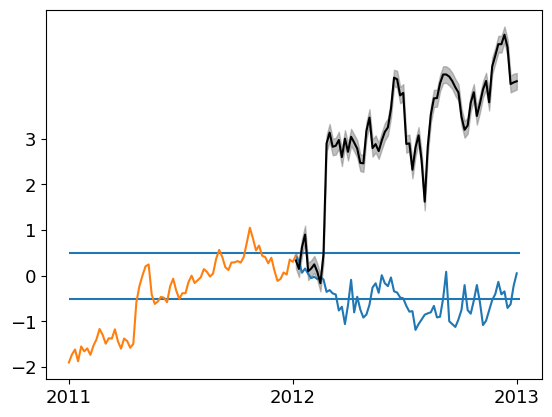

In [78]:
lookback = 74
x_future = range(train_size, train_size+test_size)
x_past = range(train_size-lookback, train_size+1)

plt.plot(x_future, y_used[train_size:test_size+train_size])

plt.fill_between(x_future, predictions.yhat_lower, predictions.yhat_upper, color="grey", alpha=0.5)
plt.plot(x_future, predictions.yhat, color="black")

plt.plot(x_past, y_used[train_size-lookback:train_size+1])
mean_absolute_error(y[train_size:test_size+train_size], predictions[["yhat"]])

xticks_range = range(train_size-lookback, train_size+test_size, 73)
xticks_year = [dt[i].year for i in xticks_range]
plt.xticks(xticks_range, xticks_year);
plt.yticks(range(-2, 4));

plt.hlines([0.5, -0.5], train_size-lookback, train_size+test_size)

In [70]:
r2_score(predictions.yhat, y_used[train_size:test_size+train_size])

0.1475177465654477

<module 'matplotlib.pyplot' from '/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/matplotlib/pyplot.py'>

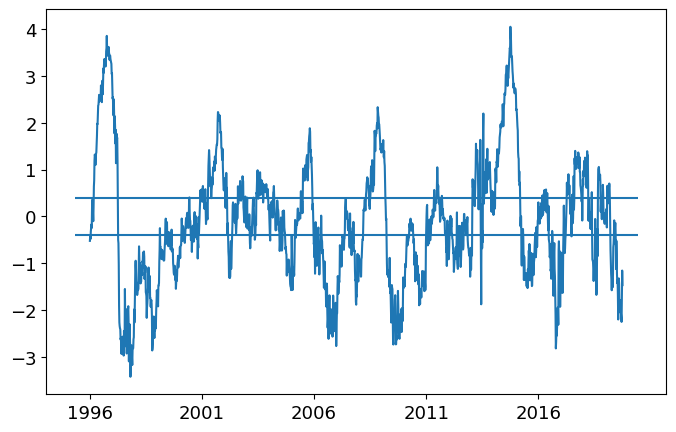

In [69]:
import matplotlib

matplotlib.style.use('default') 
font = {'size'   : 13}
matplotlib.rc('font', **font)

plt.figure(figsize=(8, 5))
plt.plot(y_used)
step = 73*5
xticks_range = range(0, len(y_used), step)
xticks_year = [dt[i].year for i in xticks_range]
plt.xticks(xticks_range, xticks_year);
plt.hlines([0.4, -0.4], -50, len(y)+50)
plt